### Experiment: Formulation

**Question**: Which option is better?
- A 2D data formulation (`channels` * `samples`)
- A topological 3D formulation (`x` * `y` * `samples`) that positions the channels similar to their physical location

**Hypothesis**: The topological 3D formulation should have more inherent information regarding the relative location of each electrode, meaning that inter-channel similarities should be easier to extract. A topological 3D formulation should therefore be better at extracting features with regard to physical location.

**Result**:

#### Part 1: Investigation

In [1]:
import numpy as np
import pandas as pd
import mne
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

##### Show electrode montage layout

Extracting parameters from /mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr...
Setting channel info structure...


/tmp/ipykernel_11536/941089869.py:4: RuntimeWarning: The unit for channel(s) A1, A2 has changed from V to NA.
  raw.set_channel_types(
/tmp/ipykernel_11536/941089869.py:8: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage("standard_1020")  # Standard 10-20 electrode montage


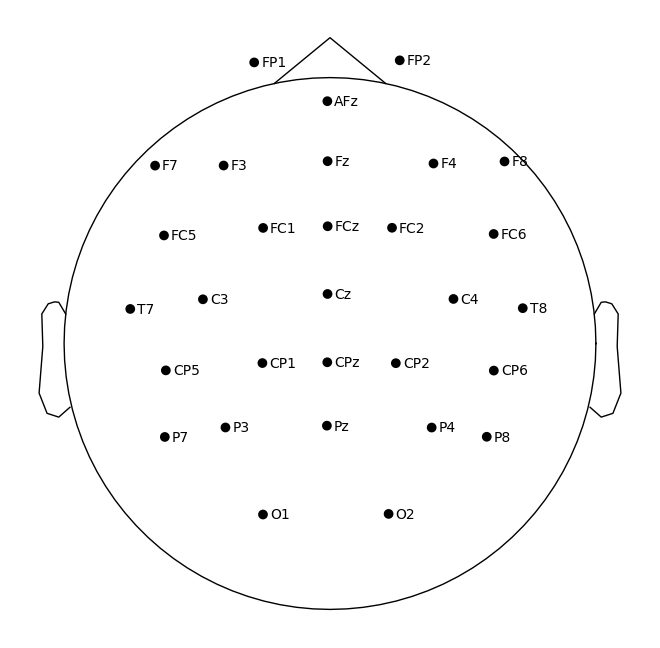

In [9]:
raw = mne.io.read_raw_brainvision(
    Path("/mnt/d/thesis/sat1/eeg4/MD3-0021.vhdr"), preload=False
)
raw.set_channel_types(
    {"EOGh": "eog", "EOGv": "eog", "A1": "misc", "A2": "misc"}
)  # Declare type to avoid confusion with EEG channels
raw.rename_channels({"FP1": "Fp1", "FP2": "Fp2"})  # Naming convention
raw.set_montage("standard_1020")  # Standard 10-20 electrode montage
raw.rename_channels({"Fp1": "FP1", "Fp2": "FP2"})

montage = raw.get_montage()
plot = montage.plot()
plt.show()

##### Replicate layout
Method of creating a sparse array retaining physical nearness adapted from Liu, Yang (2021)

In [12]:
CHANNELS_2D = np.array(
    [
        ["NA", "Fp1", "NA", "Fp2", "NA"],
        ["NA", "NA", "AFz", "NA", "NA"],
        ["F7", "F3", "Fz", "F4", "F8"],
        ["FC5", "FC1", "FCz", "FC2", "FC6"],
        ["T7", "C3", "Cz", "C4", "T8"],
        ["CP5", "CP1", "CPz", "CP2", "CP6"],
        ["P7", "P3", "Pz", "P4", "P8"],
        ["NA", "O1", "NA", "O2", "NA"],
    ],
    dtype=str,
)
print(pd.DataFrame(CHANNELS_2D))

     0    1    2    3    4
0   NA  Fp1   NA  Fp2   NA
1   NA   NA  AFz   NA   NA
2   F7   F3   Fz   F4   F8
3  FC5  FC1  FCz  FC2  FC6
4   T7   C3   Cz   C4   T8
5  CP5  CP1  CPz  CP2  CP6
6   P7   P3   Pz   P4   P8
7   NA   O1   NA   O2   NA


#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
from hmpai.utilities import CHANNELS_2D, print_results
from hmpai.pytorch.models import *
from hmpai.pytorch.training import k_fold_cross_validate
from hmpai.normalization import *
from hmpai.data import SAT1_STAGES_ACCURACY

In [2]:
data_path = Path("../data/sat1/split_stage_data_100hz.nc")
data = xr.load_dataset(data_path)

logs_path = Path("../logs/exp_formulation/")

height, width = CHANNELS_2D.shape
n_folds = 25
normalization_fn = norm_min1_to_1

##### Base model, no topological formulation

In [3]:
model = SAT1Base
model_kwargs = {
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "base"},
    "additional_name": f"formulation-base",
    "labels": SAT1_STAGES_ACCURACY,
}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8778173190984578
Fold 1: F1-Score: 0.8835294042582295
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8505747126436781
Fold 2: F1-Score: 0.8434259576764486
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8903614457831325
Fold 3: F1-Score: 0.8865009361666598
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8361858190709046
Fold 4: F1-Score: 0.8396814694829328
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.901863354037267
Fold 5: F1-Score: 0.9076672360976128
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8866103739445115
Fold 6: F1-Score: 0.8938892497521496
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8556566970091027
Fold 7: F1-Score: 0.8580407259180951
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8702830188679245
Fold 8: F1-Score: 0.8613641027901272
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9361948955916474
Fold 9: F1-Score: 0.9329667870669637
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8529769137302552
Fold 10: F1-Score: 0.8518887179778225
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9105793450881612
Fold 11: F1-Score: 0.9145815607244477
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.8856088560885609
Fold 12: F1-Score: 0.8870741851346942
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8545034642032333
Fold 13: F1-Score: 0.8616304079348331
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8515850144092219
Fold 14: F1-Score: 0.8552383825812481
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9140811455847255
Fold 15: F1-Score: 0.9137691046509782
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9425901201602136
Fold 16: F1-Score: 0.9430870537887216
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8436317780580076
Fold 17: F1-Score: 0.8442752153426527
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.871007371007371
Fold 18: F1-Score: 0.8708750075153233
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9305177111716622
Fold 19: F1-Score: 0.9306251491431011
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.8982412060301508
Fold 20: F1-Score: 0.9000594562269637
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9089790897908979
Fold 21: F1-Score: 0.907752201485518
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.8913043478260869
Fold 22: F1-Score: 0.891211745564416
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.8978562421185372
Fold 23: F1-Score: 0.8988642441050463
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8143236074270557
Fold 24: F1-Score: 0.8240510991480738
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.8844282238442822
Fold 25: F1-Score: 0.885644096082576
Accuracies
[0.8778173190984578, 0.8505747126436781, 0.8903614457831325, 0.8361858190709046, 0.901863354037267, 0.8866103739445115, 0.8556566970091027, 0.8702830188679245, 0.9361948955916474, 0.8529769137302552, 0.9105793450881612, 0.8856088560885609, 0.8545034642032333, 0.8515850144092219, 0.9140811455847255, 0.9425901201602136, 0.8436317780580076, 0.871007371007371, 0.9305177111716622, 0.8982412060301508, 0.9089790897908979, 0.8913043478260869, 0.8978562421185372, 0.8143236074270557, 0.8844282238442822]
F1-Scores
[0.8835294042582295, 0.8434259576764486, 0.8865009361666598, 0.8396814694829328, 0.9076672360976128, 0.8938892497521496, 0.8580407259180951, 0.8613641027901272, 0.9329667870669637, 0.8518887179778225, 0.9145815607244477, 0.8870741851346942, 0.8616304079348331, 0.8552383825812481, 0.9137691046509782, 0.9430870537887216, 0.8442752153426527, 0.8708750075153233, 0.9306251491431011, 0.9000594562269637, 0.90

##### Topological model without topological convolution

In [4]:
model = SAT1Topological
model_kwargs = {
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological-noconv"},
    "additional_name": f"formulation-topological-noconv",
    "labels": SAT1_STAGES_ACCURACY,
}
gen_kwargs = {"shape_topological": True}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
    gen_kwargs=gen_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8730723606168446
Fold 1: F1-Score: 0.8752059187277699
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8467432950191571
Fold 2: F1-Score: 0.8368104288125229
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8819277108433735
Fold 3: F1-Score: 0.878042552934993
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8276283618581907
Fold 4: F1-Score: 0.8313430737090247
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.8993788819875776
Fold 5: F1-Score: 0.9040226665027232
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8576598311218335
Fold 6: F1-Score: 0.8650495227726722
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8296488946684005
Fold 7: F1-Score: 0.8312408252795617
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8679245283018868
Fold 8: F1-Score: 0.8611211212414842
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9211136890951276
Fold 9: F1-Score: 0.9185723805133108
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8602673147023087
Fold 10: F1-Score: 0.8629758777724792
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9181360201511335
Fold 11: F1-Score: 0.9212666424038432
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.8929889298892989
Fold 12: F1-Score: 0.894872717346528
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8533487297921478
Fold 13: F1-Score: 0.8614848861298086
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8328530259365994
Fold 14: F1-Score: 0.8354121977309392
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9128878281622912
Fold 15: F1-Score: 0.9118292347476198
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9506008010680908
Fold 16: F1-Score: 0.9511990803091033
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8461538461538461
Fold 17: F1-Score: 0.8477848529680088
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

KeyboardInterrupt: 

##### Topological model with topological convolution

In [ ]:
model = SAT1TopologicalConv
model_kwargs = {
    "n_x": width,
    "n_y": height,
    "n_samples": len(data.samples),
    "n_classes": len(data.labels),
}
train_kwargs = {
    "logs_path": Path("../logs/exp_formulation/"),
    "additional_info": {"formulation": "topological"},
    "additional_name": f"formulation-topological",
    "labels": SAT1_STAGES_ACCURACY,
}
gen_kwargs = {"shape_topological": True}
results = k_fold_cross_validate(
    model,
    model_kwargs,
    data,
    n_folds,
    normalization_fn=normalization_fn,
    train_kwargs=train_kwargs,
    gen_kwargs=gen_kwargs,
)
print_results(results)

Fold 1: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8529062870699882
Fold 1: F1-Score: 0.8572699060987196
Fold 2: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.8045977011494253
Fold 2: F1-Score: 0.7924727725167623
Fold 3: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8746987951807229
Fold 3: F1-Score: 0.8745469120466929
Fold 4: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.80440097799511
Fold 4: F1-Score: 0.8117391466698638
Fold 5: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.901863354037267
Fold 5: F1-Score: 0.9067120705977458
Fold 6: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8685162846803377
Fold 6: F1-Score: 0.8754482489128392
Fold 7: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.8192457737321196
Fold 7: F1-Score: 0.8213153750182958
Fold 8: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.8561320754716981
Fold 8: F1-Score: 0.8515519393480158
Fold 9: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9164733178654292
Fold 9: F1-Score: 0.9166380668732813
Fold 10: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.8493317132442284
Fold 10: F1-Score: 0.8493807816606601
Fold 11: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.8954659949622166
Fold 11: F1-Score: 0.8982151516897364
Fold 12: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9028290282902829
Fold 12: F1-Score: 0.9039070627201038
Fold 13: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8441108545034642
Fold 13: F1-Score: 0.8537635642098117
Fold 14: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.792507204610951
Fold 14: F1-Score: 0.7902288763532856
Fold 15: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9152744630071599
Fold 15: F1-Score: 0.9160527411836753
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9279038718291055
Fold 16: F1-Score: 0.928234819421277
Fold 17: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.819672131147541
Fold 17: F1-Score: 0.82379489171684
Fold 18: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8869778869778869
Fold 18: F1-Score: 0.8886404272508516
Fold 19: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9128065395095368
Fold 19: F1-Score: 0.9119645959472708
Fold 20: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.8919597989949749
Fold 20: F1-Score: 0.8955307300294233
Fold 21: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8929889298892989
Fold 21: F1-Score: 0.8921635958144487
Fold 22: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.8864734299516909
Fold 22: F1-Score: 0.8899840519241472
Fold 23: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.8738965952080706
Fold 23: F1-Score: 0.8776765430785861
Fold 24: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

  0%|          | 0/152 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8037135278514589
Fold 24: F1-Score: 0.8135273165589891
Fold 25: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

  0%|          | 0/151 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.8637469586374696
Fold 25: F1-Score: 0.8667782307678881
Accuracies
[0.8529062870699882, 0.8045977011494253, 0.8746987951807229, 0.80440097799511, 0.901863354037267, 0.8685162846803377, 0.8192457737321196, 0.8561320754716981, 0.9164733178654292, 0.8493317132442284, 0.8954659949622166, 0.9028290282902829, 0.8441108545034642, 0.792507204610951, 0.9152744630071599, 0.9279038718291055, 0.819672131147541, 0.8869778869778869, 0.9128065395095368, 0.8919597989949749, 0.8929889298892989, 0.8864734299516909, 0.8738965952080706, 0.8037135278514589, 0.8637469586374696]
F1-Scores
[0.8572699060987196, 0.7924727725167623, 0.8745469120466929, 0.8117391466698638, 0.9067120705977458, 0.8754482489128392, 0.8213153750182958, 0.8515519393480158, 0.9166380668732813, 0.8493807816606601, 0.8982151516897364, 0.9039070627201038, 0.8537635642098117, 0.7902288763532856, 0.9160527411836753, 0.928234819421277, 0.82379489171684, 0.8886404272508516, 0.9119645959472708, 0.8955307300294233, 0.8921635

View results in TensorBoard

In [6]:
# View results in Tensorboard
! tensorboard --logdir logs/exp_formulation/

2023-10-13 14:05:48.740655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
